In [1]:
%matplotlib inline
import os
import category_encoders as ce
import pandas as pd
import numpy as np
import scipy as sp
from pdpbox import pdp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from models import data_helper
dh = data_helper
data = dh.load_in_data()
data = dh.wrangler(data)

# Baseline Predictions:
print(f"Baseline Classifications: \n{data.injSeverity.value_counts(normalize=True)}\n")

Baseline Classifications: 
mid     0.365649
low     0.346587
high    0.287765
Name: injSeverity, dtype: float64



Confusion Matrix: 


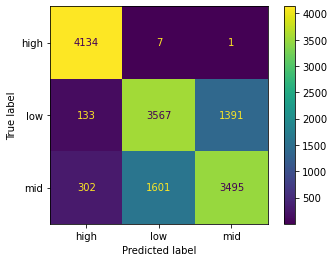

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


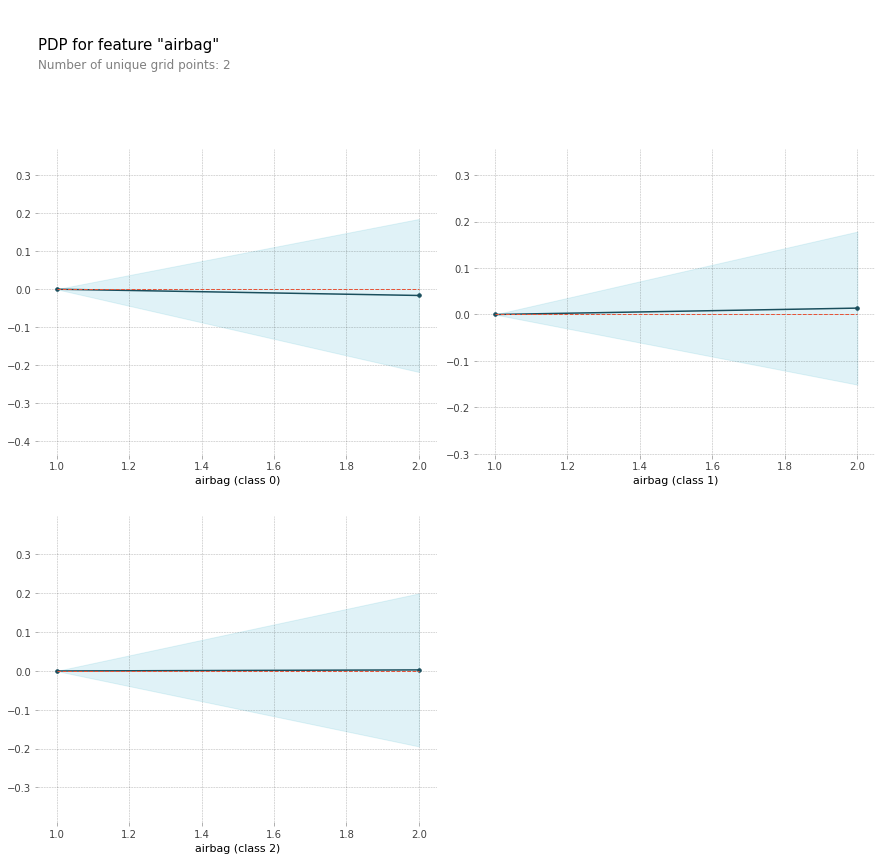

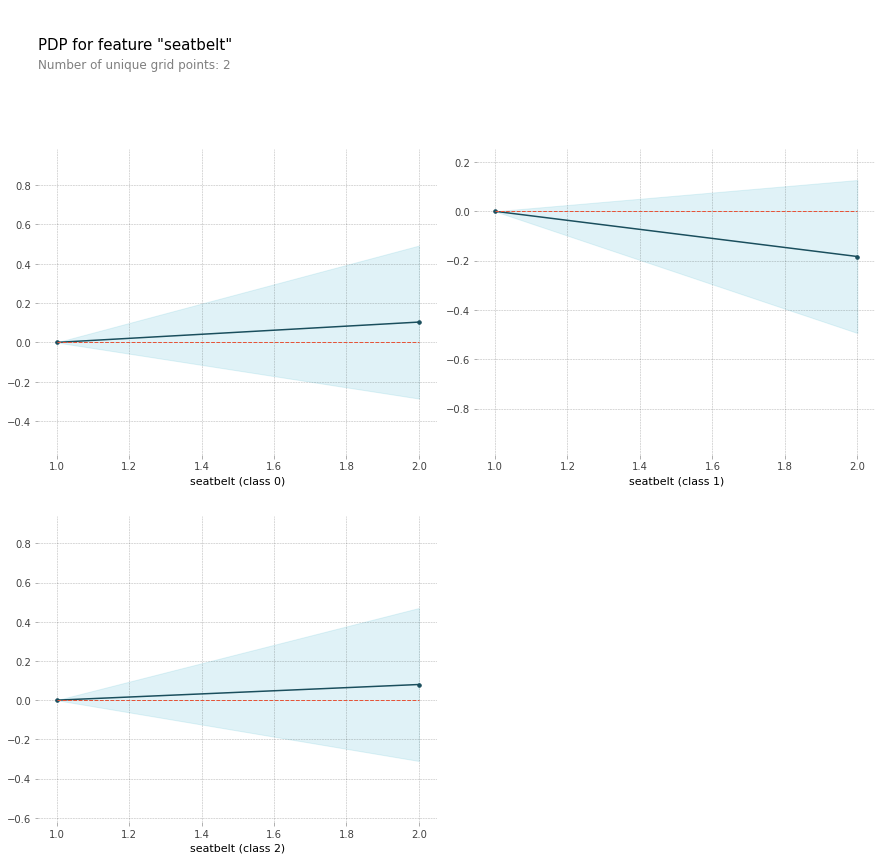

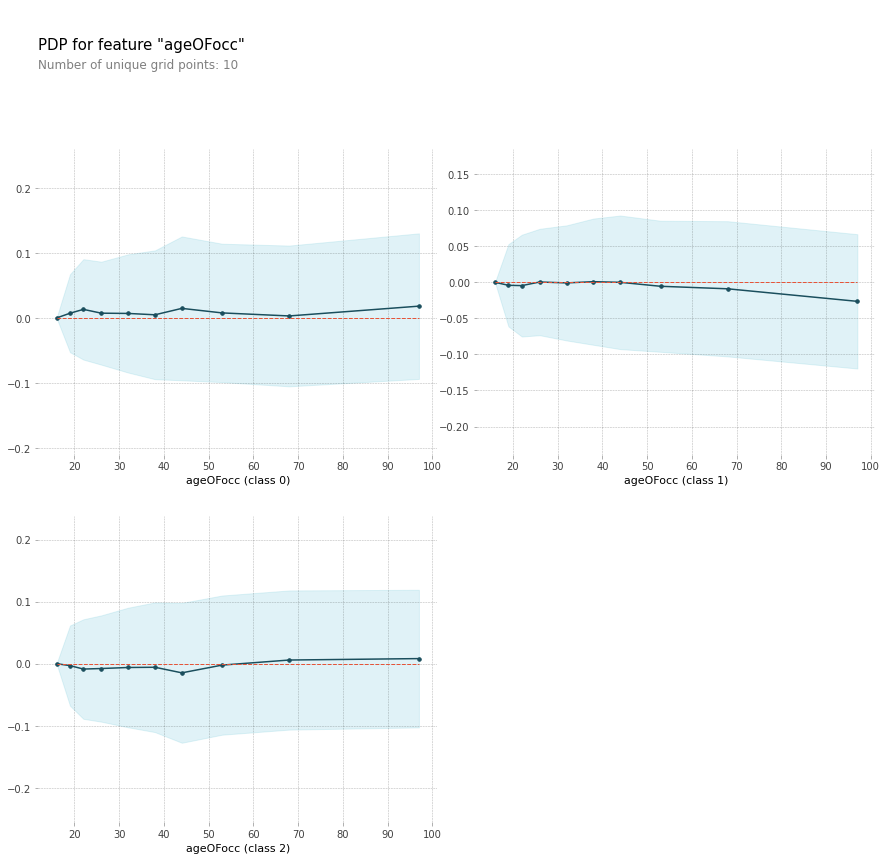

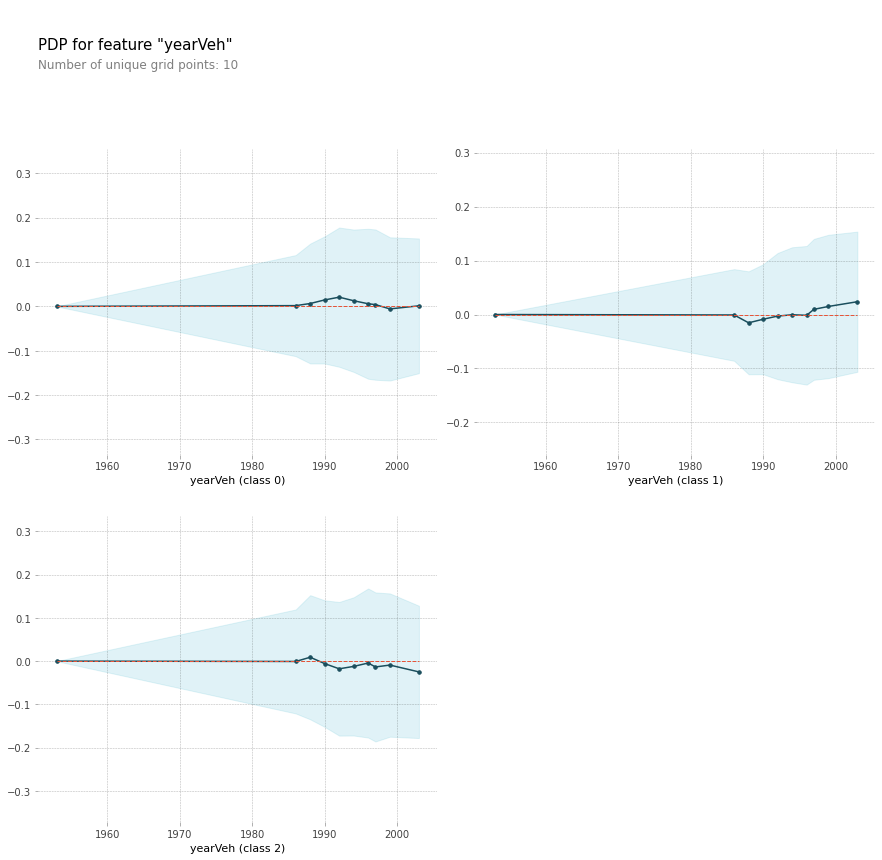

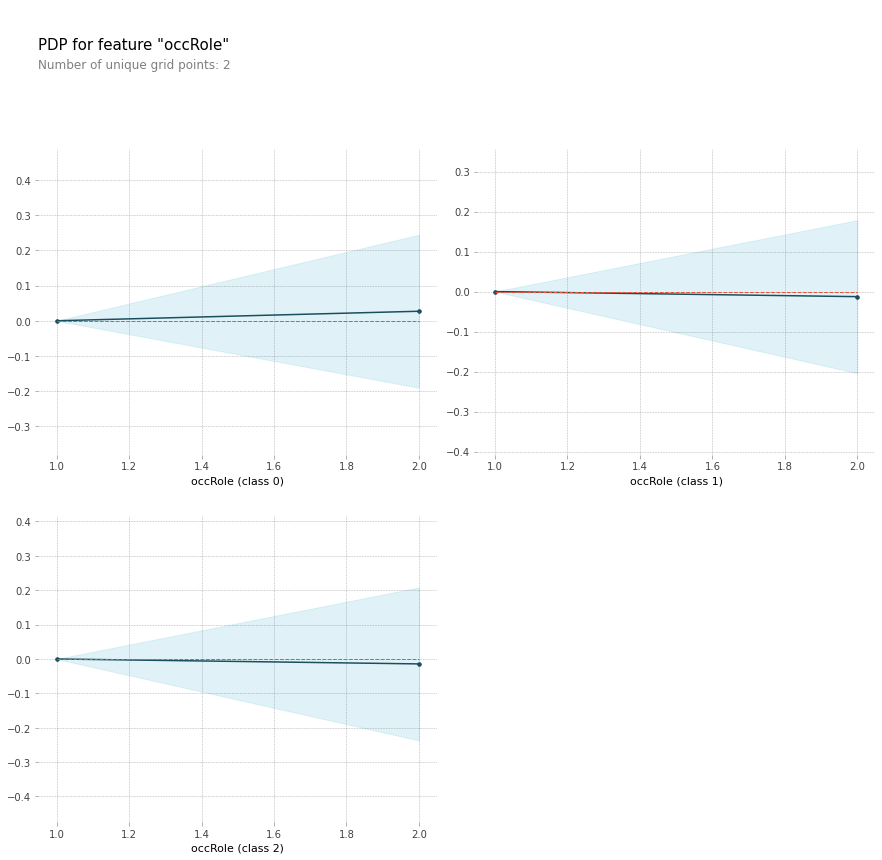

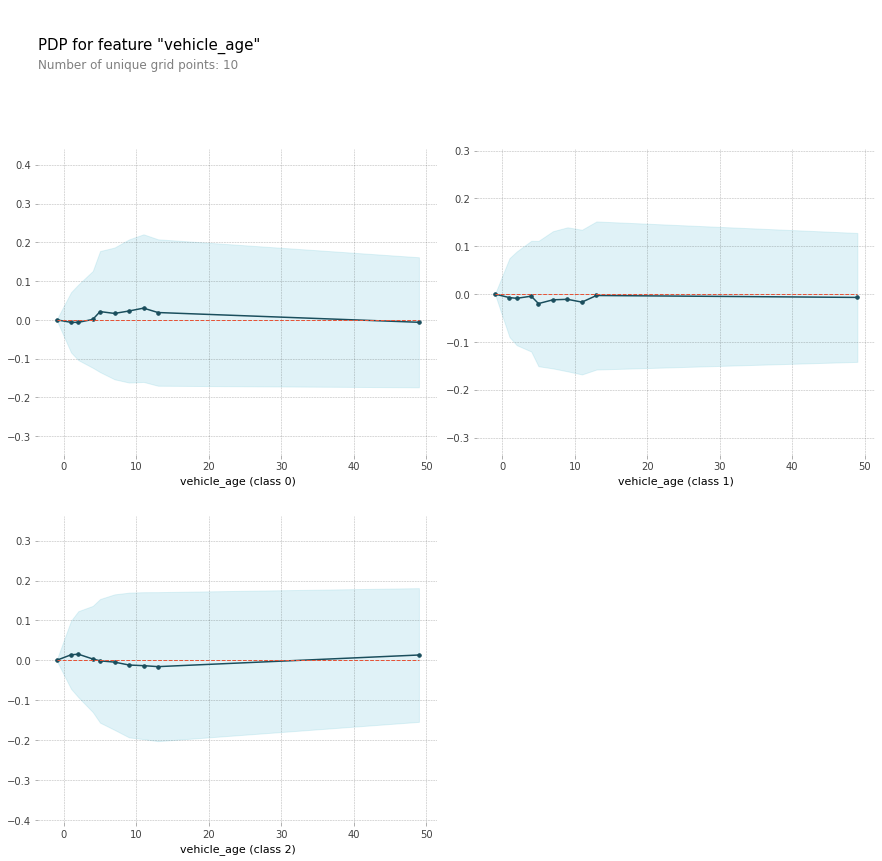

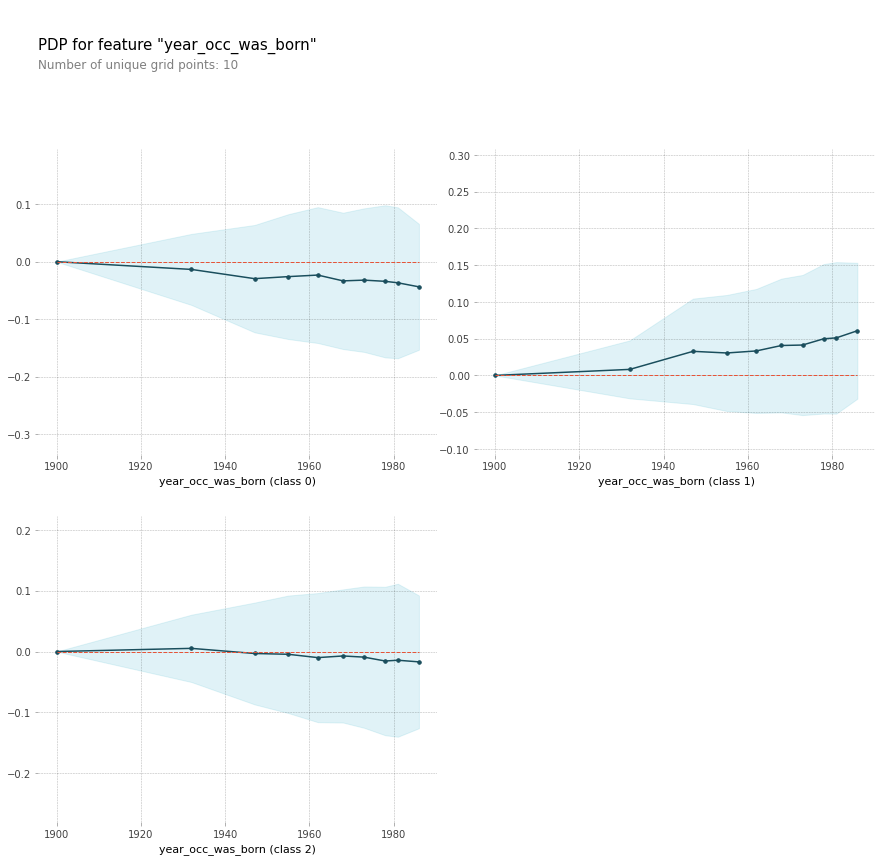

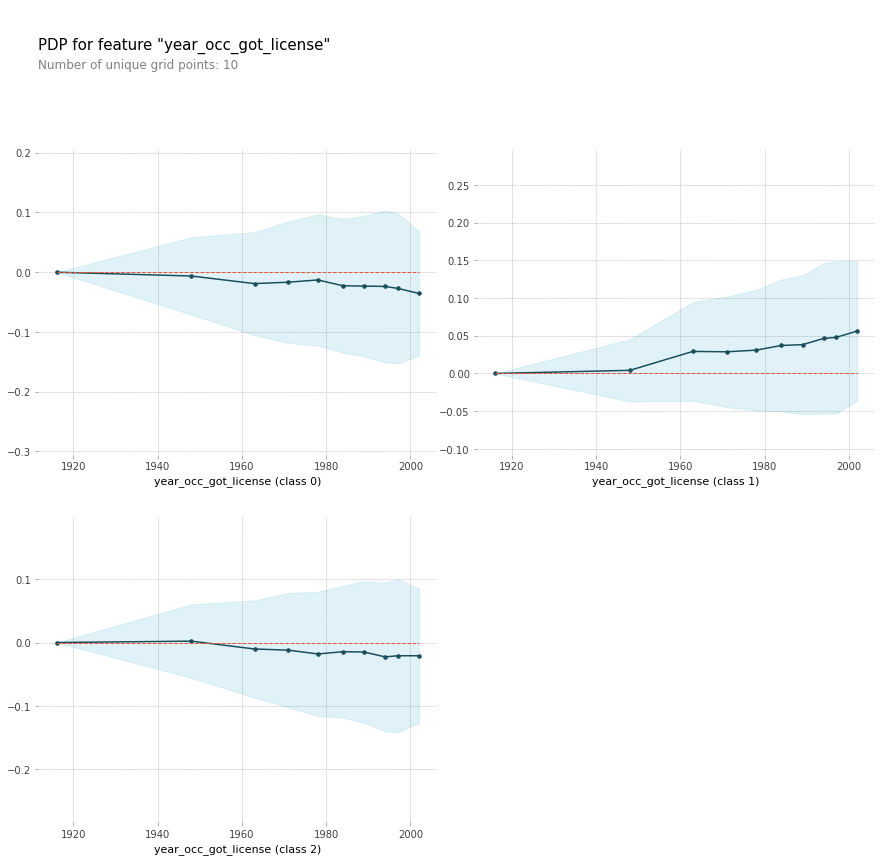

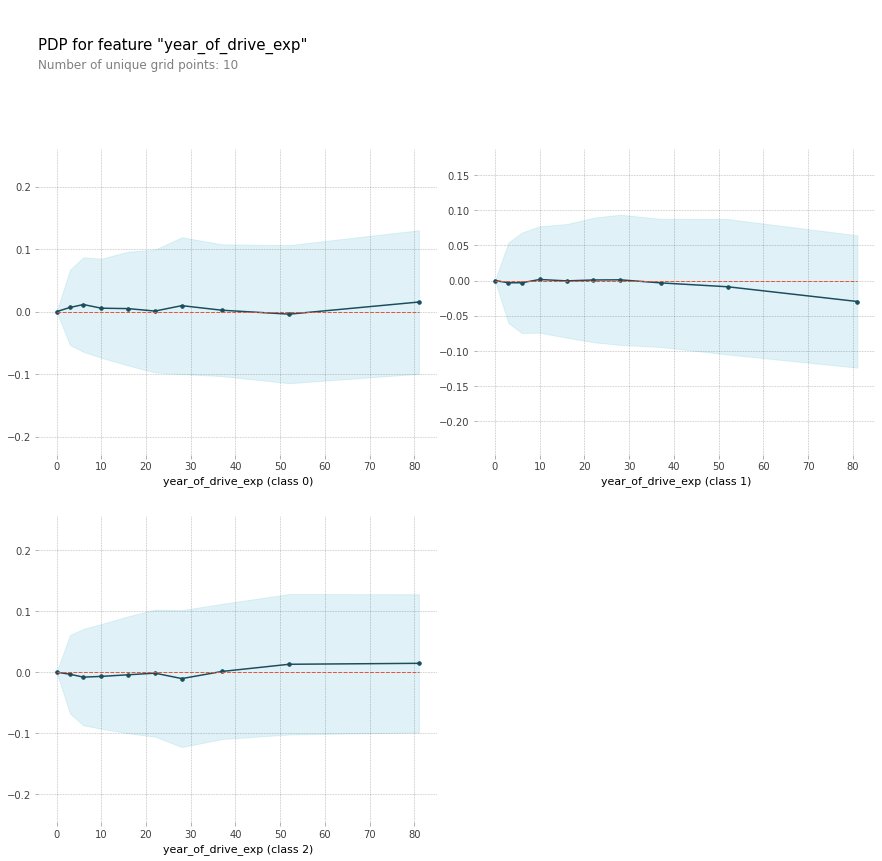

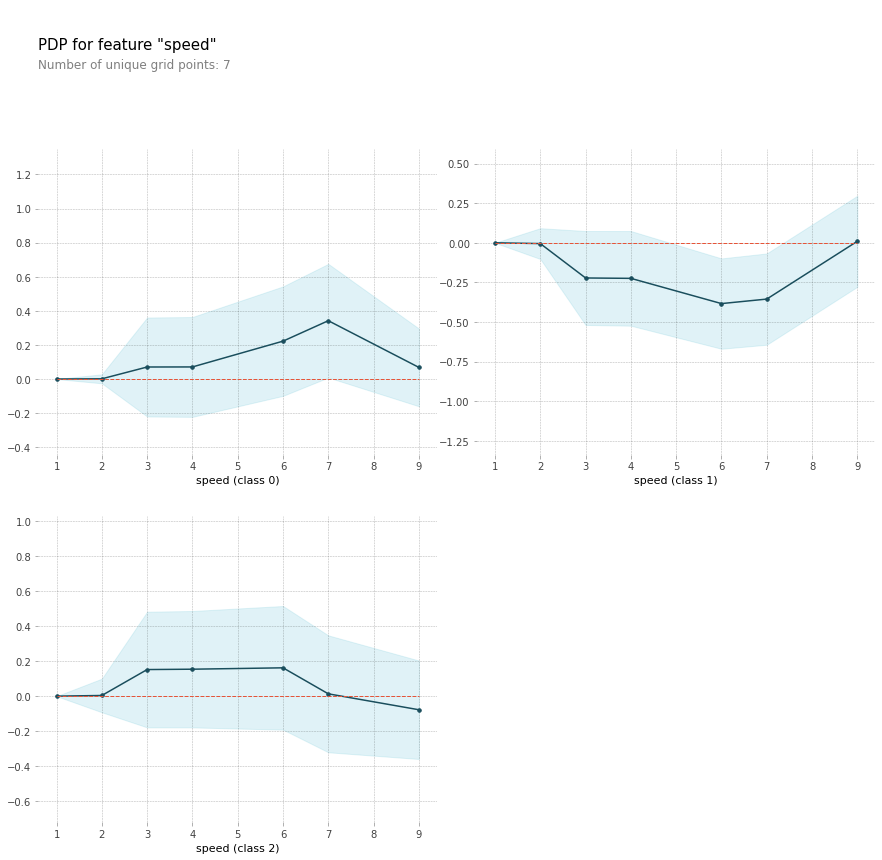

In [2]:
# Engineer new featuress:
data = dh.engineer_features(data)

# Split data into train val test:
train, val, test = dh.split_data(data, True)

# Features removed for ethical, poor-data, and data-leakage: 
removed_features = [
    'dvcat', 'frontal', 'sex',
    'avg_speed', 'yearacc']

# Acctual features to use:
features = [
    'airbag', 'seatbelt',
    'ageOFocc', 'yearVeh', 'occRole', 'vehicle_age',
    'year_occ_was_born', 'year_occ_got_license',
    'year_of_drive_exp', 'speed']

# Declare target variable:
target = 'injSeverity'

# Instantiate encoder:
encoder = ce.OrdinalEncoder()

# Encode data:
train_feat = encoder.fit_transform(train[features])
val_feat = encoder.transform(val[features])
test_feat = encoder.transform(test[features])

# Asign Train Val and Test:
X_train, y_train = train_feat, train[target]
X_val, y_val = val_feat, val[target]
X_test, y_test = test_feat, test[target]

# Create First model Random Forest:
model_1, score, y_pred, y_prob = dh.make_model(
    X_train, y_train,
    X_val, y_val,
    RandomForestClassifier(
        n_jobs=-1,
        random_state=42,
        n_estimators=323,    ## Hyper params tunned by RandomizedSearchCV below
        max_depth=20,
        criterion='gini', ))

# Plot partial dependencies for each feature:
for col in X_train.columns:
    feature = col
    pdp_dist = pdp.pdp_isolate(
        model=model_1,
        dataset=X_train,
        model_features=X_train.columns,
        feature=feature,
        n_jobs=-1, )
    pdp.pdp_plot(pdp_dist, feature)
    pdp.plt.show();

In [3]:
import shap

# Index to predict on:
index = 12717
row = X_val.iloc[[index]]

print(row)  # print row inputs
print("Predicted: ", model_1.predict(row))  # print the predicted value
print("Actual: ", y_val.iloc[[index]])  # print the true value
print("Accuracy Score: ", score)  # print the accuracy score

# Instantiate the shaply explainer:
explainer = shap.TreeExplainer(model_1)
# Explain values:
shap_values = explainer.shap_values(row)

# Get the row prediction:
y_pred_row = model_1.predict(row)

# Instantiate mapping variables:
low = 1
mid = 2
high = 0

# Initialize javascript to display plot:
shap.initjs()

if y_pred_row == 'low':
    display(shap.force_plot(
        base_value=explainer.expected_value[low],
        shap_values=shap_values[low],
        features=row,
        link='logit'
    ))

if y_pred_row == 'mid':
    display(shap.force_plot(
        base_value=explainer.expected_value[mid],
        shap_values=shap_values[mid],
        features=row,
        link='logit'
    ))

if y_pred_row == 'high':
    display(shap.force_plot(
        base_value=explainer.expected_value[high],
        shap_values=shap_values[high],
        features=row,
        link='logit'
    ))

       airbag  seatbelt  ageOFocc  yearVeh  occRole  vehicle_age  \
14881       2         1        35     1998        2            2   

       year_occ_was_born  year_occ_got_license  year_of_drive_exp  speed  
14881               1965                  1981                 19      1  
Predicted:  ['low']
Actual:  14881    mid
Name: injSeverity, dtype: object
Accuracy Score:  0.7652245232725036


In [4]:
# Ranomized Search CV for hyper param tuning:

data = dh.engineer_features(data)
train2, test2 = dh.split_data(data)
encoder2 = ce.OrdinalEncoder()
train_feat2 = encoder2.fit_transform(train2[features])
test_feat2 = encoder2.transform(test2[features])
X_train2, y_train2 = train_feat2, train2[target]
X_test2, y_test2 = test_feat2, test2[target]
rfc = RandomForestClassifier()
param_dist = {
    'criterion': ['entropy', 'gini'],
    'max_depth': [5, 10, 15, 20, 25],
    'n_estimators': [100, 200, 250, 300, 350, 400], }
search_2 = RandomizedSearchCV(
    rfc,
    param_distributions=param_dist,
    n_iter=10,
    n_jobs=-1,
    cv=5,
    random_state=42,
    verbose=10,
    return_train_score=True,
    scoring='accuracy', )
search_2.fit(X_train2, y_train2)
print("Best Estimator:\n{}".format(search_2.best_estimator_))
print("\nBest Score: {}".format(search_2.best_score_))
print("\nBest Params: {}".format(search_2.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.9min finished


Best Estimator:
RandomForestClassifier(max_depth=25, n_estimators=300)

Best Score: 0.8408032637120462

Best Params: {'n_estimators': 300, 'max_depth': 25, 'criterion': 'gini'}


Confusion Matrix: 


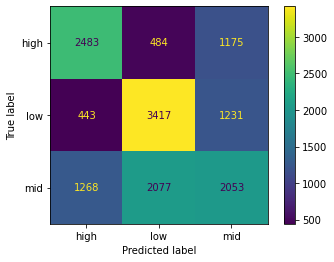

In [5]:
# Linear model using Logistic Regression:
model_3, score, y_pred, y_prob = dh.make_model(
    X_train, y_train,
    X_val, y_val,
    LogisticRegressionCV(
        random_state=42,
        n_jobs=-1,
        penalty='l2',
        solver='newton-cg',
        max_iter=100,
        scoring='accuracy', ))

In [9]:
final_random_forest_pred = model_1.predict(X_test)
final_random_forest_score = accuracy_score(y_pred=final_random_forest_pred,
                                          y_true=y_test)
print("Final Score: ", final_random_forest_score)

Final Score:  0.7752739103392182


In [10]:
final_logistic_regression_pred = model_3.predict(X_test)
final_logistic_regression_score = accuracy_score(y_pred=final_logistic_regression_pred,
                                                y_true=y_test)
print("Final Score: ", final_logistic_regression_score)

Final Score:  0.5517439356968566
